<a href="https://colab.research.google.com/github/TristanNagan/RL-Assignment-2020-NetHack/blob/main/RL_Assignment_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
!pip3 install box2d-py

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 788kB 2.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import torch
import torch.nn as nn

import random
from collections import deque
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
import imageio

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [ ]:
display.screen

0

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class A2C(nn.Module):
  def __init__(self, observation_space, action_space, hidden_size):
    super(A2C, self).__init__()

    # self.actor = nn.Sequential(
    #               nn.Linear(observation_space, hidden_size),
    #               nn.ReLU(),
    #               nn.Linear(hidden_size, action_space),
    #               nn.Softmax(dim=-1)
    #             )
    
    # self.critic = nn.Sequential(
    #               nn.Linear(observation_space, hidden_size),
    #               nn.ReLU(),
    #               nn.Linear(hidden_size, 1)
    #             )
    self.input_layer = nn.Linear(observation_space, hidden_size)
    self.actor_layer = nn.Linear(hidden_size, action_space)
    self.critic_layer = nn.Linear(hidden_size, 1)
    
  def forward(self, state):
    state = torch.from_numpy(state).float().to(device)
    # policy = self.actor(state)
    # state_value = self.critic(state)
    state = torch.nn.functional.relu(self.input_layer(state))
    state_value = self.critic_layer(state)
    policy = torch.nn.functional.softmax(self.actor_layer(state), dim=-1)
    return state_value, policy

  def loss(self, probs, values, rewards, gamma, entropy):
    # print(rewards)
    returns = []
    discounted_reward = 0
    for reward in rewards[::-1]:
      discounted_reward = reward + gamma*discounted_reward
      returns.insert(0, discounted_reward)
    
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std())
    # print(returns)
    # # print(probs)
    # # print(values)
    loss = 0
    for logprob, value, reward in zip(probs, values, returns.float()):
    #     # print(logprob.dtype, value.dtype, reward.float().dtype)
    #     # print(value.item())
        advantage = reward  - value.item()
    #     # print(advantage)
        action_loss = -logprob * advantage
    #     # print(action_loss)
    #     # print(value.shape)
    #     # print(reward.unsqueeze(0).shape)
        value_loss = torch.nn.functional.smooth_l1_loss(value, reward.unsqueeze(0))
    #     # print(value_loss)
        loss += (action_loss + value_loss)
    #     # print(loss)
    #     # break
    # print(returns)
    # returns = torch.FloatTensor(returns).detach()
    # print(probs)
    # probs = torch.cat(probs)#.unsqueeze(1)
    # print(probs)
    # values = torch.cat(values)
    # print(values)
    # advantage = returns - values
    # actor_loss = (-probs * advantage.detach()).mean()
    # critic_loss = advantage.pow(2).mean()
    # loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy
    # print(loss.dtype)
    return loss.float()


In [ ]:
env = wrap_env(gym.make('LunarLander-v2'))
env.action_space

Discrete(4)

In [ ]:
# env = wrap_env(gym.make('LunarLander-v2'))
# env = gym.make('LunarLander-v2')
seed = 42
learning_rate = 0.02
max_episodes = 300
max_episode_length = 1000
gamma = 0.99

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

env.seed(seed)

scores = []
model = A2C(env.observation_space.shape[0], env.action_space.n, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scores_deque = deque(maxlen=100)

for episode in range(max_episodes):
  state = env.reset()
  probs = []
  rewards = []
  values = []
  masks = []
  entropy = 0
  for step in range(max_episode_length):
    state_value, policy = model.forward(state)

    action_probs = torch.distributions.Categorical(policy)
    action = action_probs.sample()

    probs.append(action_probs.log_prob(action))
    entropy += action_probs.entropy().mean()
    values.append(state_value)
    # print(action)
    # print(action.item())
    # print(action.cpu().numpy())
    state, reward, done, _ = env.step(action.item())
    # print(torch.tensor(reward).float().unsqueeze(0))
    rewards.append(reward)
    # rewards.append(torch.tensor(reward).float().unsqueeze(0).to(device))
    # masks.append(torch.tensor(1 - done).float().unsqueeze(0).to(device))
    if done:
      break
  
  scores.append(sum(rewards))
  scores_deque.append(sum(rewards))
  loss = model.loss(probs, values, rewards, gamma, entropy)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if episode % 50 == 0:
    print('Episode [{}/{}]\t Average Score = {:.2f}'.format(episode, max_episodes, np.mean(scores_deque)))

Episode [0/300]	 Average Score = -51.77
Episode [50/300]	 Average Score = -211.39
Episode [100/300]	 Average Score = -181.70
Episode [150/300]	 Average Score = -137.68
Episode [200/300]	 Average Score = -121.27
Episode [250/300]	 Average Score = -92.98


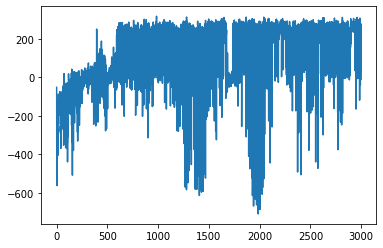

In [ ]:
plt.plot(np.arange(3000), scores, label='Score')

In [ ]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for i in range(1000):
  state_value, policy = model.forward(state)
  action_probs = torch.distributions.Categorical(policy)
  action = action_probs.sample()
  img.set_data(env.render(mode='rgb_array')) 
  plt.axis('off')
  display.display(plt.gcf())
  display.clear_output(wait=True)
  state, reward, done, _ = env.step(action.item())
  if done:
    break
show_video()

NameError: ignored

In [ ]:
import imageio

In [ ]:
frames = []
state = env.reset()
for i in range(1000):
  frames.append(env.render(mode = 'rgb_array'))
  state_value, policy = model.forward(state)
  action_probs = torch.distributions.Categorical(policy)
  action = action_probs.sample()
  state, reward, done, _ = env.step(action.item())
  if done:
    break
imageio.mimsave("./agent.gif", frames)

In [ ]:
%%bash
apt-get install -y xvfb x11-utils
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.7 [783 kB]
Fetched 993 kB in 1s (1,287 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
S

In [ ]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.2.10
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.2.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
box2d-py==2.3.8
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
certifi==2020.6.20
cffi==1.14.3
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.3
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
debugpy==1.0.0rc2
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.2
distributed==1.25.3
Django==3.1.1
dlib==19.18.0
dm-tree=

In [ ]:
import pyglet.gl

NameError: ignored

In [ ]:
state = env.reset()
for i in range(1000):
  env.render()
  state_value, policy = model.forward(state)
  action_probs = torch.distributions.Categorical(policy)
  action = action_probs.sample()
  state, reward, done, _ = env.step(action.item())
  if done:
    break
env.close()
show_video()

In [ ]:
!rm -r video

In [ ]:
env.render(mode = 'rgb_array')

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
import matplotlib.image as mpimg
from ipywidgets import Image

In [ ]:
mp4list = glob.glob('*.gif')
mp4 = mp4list[0]
video = io.open(mp4, 'r+b').read()
encoded = base64.b64encode(video)
ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
          </video>'''.format(encoded.decode('ascii'))))

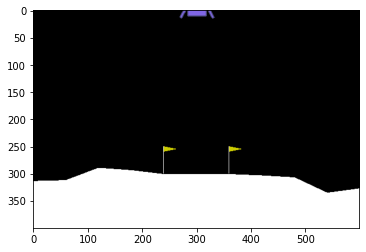

In [ ]:
img = mpimg.imread("./agent.gif")

plt.imshow(img)

In [ ]:
animatedGif = "agent.gif"
file = open(animatedGif , "rb")
image = file.read()
progress= Image(
    value=image,
    format='gif',
    width=600,
    height=400)
ipythondisplay.display(progress)

Image(value=b'GIF89aX\x02\x90\x01\x87\x00\x00\xff\xff\xff\xcc\xcc\x00\x80f\xe6LL\x80\x00\x00\x00\x00\x00\x00\x…

In [ ]:
progress.close()